<a href="https://colab.research.google.com/github/bennettJG/data17200project/blob/main/Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Display all columns for ease of reviewing data
pd.set_option('display.max_columns', 1000)

Raw data from:
Clore, J., Cios, K., DeShazo, J., & Strack, B. (2014). *Diabetes 130-US Hospitals for Years 1999-2008* [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.

The data were originally published alongside a journal article which used logistic regression methods to analyze the impact of blood glucose measurement (`A1Cresult` in the dataset) during hospitalization on readmission within 30 days for diabetic patients (`readmitted`):

Strack, B., DeShazo, J. P., Gennings, C., Olmo, J. L., Ventura, S., Cios, K. J., & Clore, J. N. (2014). Impact of HbA1c measurement on hospital readmission rates: analysis of 70,000 clinical database patient records. *BioMed research international, 2014*(1), 781670. https://doi.org/10.1155/2014/781670

Missing values on most variables are represented by '?'.

In [132]:
patients = pd.read_csv("https://raw.githubusercontent.com/bennettJG/data17200project/refs/heads/main/diabetic_data.csv", na_values=['?'], low_memory=False)
patients.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Data Cleaning

This dataset includes multiple rows for some patient IDs (`patient_nbr`) if they were hospitalized more than once. Previous admissions are likely to be predictive of future outcomes, and a patient's past medical record would be available at the time of their current admission. Thus, it makes sense to create features based on this information *before* splitting the data into train and test sets (since basing a number of past admissions on a fraction of the dataset only would underestimate the true value). The dataset contains counts of previous inpatient, outpatient, and emergency encounters within the past year, but the dataset includes data from multiple years, so a patient's previous number of admissions may exceed the sum of these values.

The `readmitted` variable in the dataset takes three (categorical) values:

*   '<30': Readmitted within 30 days
*   '>30': Readmitted after more than 30 days
*   'NO': Not readmitted

In [133]:
# Arrange in order of encounter ID -- lower IDs correspond to earlier encounters
patients.sort_values('encounter_id', inplace=True)
patients.reset_index(inplace=True, drop=True)

# Count number of previous encounters, readmissions within 30 days, readmissions after more than 30 days, total time spent in hospital
patients['prev_encounters'] = patients.groupby('patient_nbr')['encounter_id'].cumcount()
# Make sure not to include time spent during CURRENT observation in the cumulative sum! That's already a separate variable included in the observation
# so including it in a new feature and using both would introduce collinearity
patients['prev_time_hospital'] = patients.groupby('patient_nbr')['time_in_hospital'].cumsum() - patients['time_in_hospital']

patients['readmit_less30'] = patients['readmitted'] == "<30"
# Make sure not to include current admission in count!
patients['prev_readmit_less30'] = patients.groupby('patient_nbr')['readmit_less30'].cumsum() - patients['readmit_less30']

In the original paper, the authors were interested specifically in readmission within 30 days, stating that "30 days was chosen based on criteria often used by funding agencies," so it seems reasonable to use readmission within this time frame as a binary target variable. It may also be possible to fit a multiclass classification model for all three possible values of `readmitted`.

In [134]:
# Separate target from features and split into train/test sets
# Of course, we need to drop all variables based on the readmission indicator from the training data
X = patients.drop(['readmitted', 'readmit_less30'], axis=1)
y = patients['readmit_less30']
y_3cat = patients['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1701, stratify=y, test_size=0.25)
X_train2, X_test2, y_3cat_train, y_3cat_test = train_test_split(X, y_3cat, random_state=1701, stratify=y_3cat, test_size=0.25)
print(X_train.info())
print(X_train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 76324 entries, 78165 to 5773
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              76324 non-null  int64 
 1   patient_nbr               76324 non-null  int64 
 2   race                      74621 non-null  object
 3   gender                    76324 non-null  object
 4   age                       76324 non-null  object
 5   weight                    2362 non-null   object
 6   admission_type_id         76324 non-null  int64 
 7   discharge_disposition_id  76324 non-null  int64 
 8   admission_source_id       76324 non-null  int64 
 9   time_in_hospital          76324 non-null  int64 
 10  payer_code                46146 non-null  object
 11  medical_specialty         38803 non-null  object
 12  num_lab_procedures        76324 non-null  int64 
 13  num_procedures            76324 non-null  int64 
 14  num_medications         

The number of missing values for `weight` is very high, and it is unlikely that the variables we do have full information on correlate strongly enough with weight for reliable imputation.

`max_glu_serum` and `A1Cresult` are also missing for a large majority of observations. However, the original paper identifies whether or not A1C was measured -- not just the result -- as clinically relevant. To include this information in the model, I chose to replace missing values with "Not measured" for these two variables. Both were already categorical (`max_glu_serum` takes values None, 'Norm', '>200', and '>300', and `A1Cresult` takes values None, 'Norm', '>6', and '>7'), so adding an additional category for patients with no measurement and one-hot encoding seems reasonable.

There are lower numbers of missing values for `race`, `medical_specialty`, and `payer_code` (insurance type). I chose to handle these similarly by creating an "Unknown" category to complement the existing categories when the information is known.

In [135]:
X_train.drop(['weight'], axis=1, inplace=True)
X_test.drop(['weight'], axis=1, inplace=True)

X_train.fillna({'A1Cresult':'Not Measured', 'max_glu_serum': "Not Measured", 'race': 'Unknown', 'payer_code': 'Unknown', 'medical_specialty': 'Unknown'}, inplace=True)
X_test.fillna({'A1Cresult':'Not Measured', 'max_glu_serum': "Not Measured", 'race': 'Unknown', 'payer_code': 'Unknown', 'medical_specialty': 'Unknown'}, inplace=True)

Inspecting the values of the categorical columns, we can observe that some provide very little information (for example, only two patients were administered troglitazone during their admission, and none were administered examide, acetohexamide, or citoglipton). Because most of the medication variables were so uninformative, I chose to only include as features those where more than 200 patients in the training set received the medication (had values other than 'No').

In [136]:
cat_cols = X_train.select_dtypes(include='object')
for c in cat_cols:
  print(X_train[c].value_counts())

med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
med_drop = [m for m in med_cols if X_train[m].value_counts()['No'] > len(X_train) - 200]
X_train.drop(med_drop, axis=1, inplace=True)
X_test.drop(med_drop, axis=1, inplace=True)

race
Caucasian          57097
AfricanAmerican    14360
Unknown             1703
Hispanic            1526
Other               1157
Asian                481
Name: count, dtype: int64
gender
Female             41034
Male               35287
Unknown/Invalid        3
Name: count, dtype: int64
age
[70-80)     19494
[60-70)     16928
[80-90)     12902
[50-60)     12881
[40-50)      7230
[30-40)      2853
[90-100)     2130
[20-30)      1254
[10-20)       520
[0-10)        132
Name: count, dtype: int64
payer_code
Unknown    30178
MC         24338
HM          4690
SP          3793
BC          3455
MD          2649
CP          1869
UN          1811
CM          1501
OG           781
PO           461
DM           403
CH           115
WC           104
OT            78
MP            56
SI            41
FR             1
Name: count, dtype: int64
medical_specialty
Unknown                   37521
InternalMedicine          10974
Emergency/Trauma           5711
Family/GeneralPractice     5565
Cardiology  

Given the very low count of patients with unknown gender, it is probably easiest to drop these observations rather than attempt to include the uncommon value in the model.

It's also probably best to encode age as an ordinal, rather than unordered, variable.

In [137]:
X_train = X_train[X_train['gender'] != 'Unknown/Invalid']
X_test = X_test[X_test['gender'] != 'Unknown/Invalid']

ord_enc = OrdinalEncoder()
ord_enc.fit(pd.DataFrame(X_train['age']))
X_train['age'] = ord_enc.transform(pd.DataFrame(X_train['age']))
X_test['age'] = ord_enc.transform(pd.DataFrame(X_test['age']))

The columns `diag_1`, `diag_2`, `diag_3` contain ICD-9 diagnostic codes for patients' primary, secondary, and tertiary diagnoses (and may be missing if fewer than three diagnoses were provided). There are too many categories of each for one-hot encoding to be useful, but we may be able to obtain more informative features by converting the primary diagnosis to its broader ICD-9 category.

A JSON file mapping ICD-9 codes to text diagnoses and their categories/subcategories is available at https://github.com/sirrice/icd9.

In [138]:
icd_codes = pd.read_json("https://raw.githubusercontent.com/sirrice/icd9/refs/heads/master/codes.json")
icd_codes.head()
icd_cat = pd.concat(
    [pd.json_normalize(icd_codes[2])[['code', 'descr']],
    pd.json_normalize(icd_codes[1])[['descr']],
    pd.json_normalize(icd_codes[0])[['descr']]],
    axis=1
).dropna(subset=['code']).fillna("Other").drop_duplicates().set_index('code')
icd_cat.columns = ['description', 'category', 'broad_category']

# Transform values in dataset to match reference JSON -- need to pad left with zeroes and remove the part after the decimal point
# (which gives more specific detail -- but we're trying to consolidate similar conditions where)
X_train['diag_1'] = np.where(X_train['diag_1'].str.replace('.','').str.isnumeric(),
         X_train['diag_1'].str.pad(width=3, fillchar='0').str.slice(stop=3),
         X_train['diag_1'].str.slice(stop=4))
X_train = X_train.merge(icd_cat, left_on='diag_1', right_index=True)

X_test['diag_1'] = np.where(X_test['diag_1'].str.replace('.','').str.isnumeric(),
         X_test['diag_1'].str.pad(width=3, fillchar='0').str.slice(stop=3),
         X_test['diag_1'].str.slice(stop=4))
X_test = X_test.merge(icd_cat, left_on='diag_1', right_index=True)

Since diabetes is of particular interest for this patient population, whether or not it was the *primary* diagnosis for which they were hospitalized (as opposed to being present while the main complain is something else) is likely a relevant feature to include.

For now, I keep the 13-value `broad_category` and drop the over-100-value `category` variable. Potentially, unsupervised dimension reduction techniques might be applicable to identify clusters of `category` values that are similar in terms of outcome at a later stage.

In [139]:
X_train['diabetes'] = np.where(X_train['description'].str.contains("diabetes", case = False), True, False)
X_train[['description','diabetes']]
X_train.drop(['category', 'description'], axis=1, inplace=True)

X_test['diabetes'] = np.where(X_test['description'].str.contains("diabetes", case = False), True, False)
X_test[['description','diabetes']]
X_test.drop(['category', 'description'], axis=1, inplace=True)

Now let's examine the numeric variables:

In [100]:
X_train.describe()

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,prev_encounters,prev_time_hospital,prev_readmit_less30,diabetes
count,7.627500e+04,7.627500e+04,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000,76275.000000
mean,1.653098e+08,5.438087e+07,6.096768,2.018368,3.696794,5.744294,4.391032,43.029774,1.341567,15.990010,0.369689,0.196801,0.634716,7.423022,0.628738,2.898092,0.186772,0.087053
std,1.026591e+08,3.873914e+07,1.597923,1.439552,5.255040,4.050583,2.981872,19.692353,1.706828,8.095864,1.279745,0.896737,1.258281,1.935216,1.519306,7.569693,0.710697,0.281915
min,1.252200e+04,1.350000e+02,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,8.505916e+07,2.341191e+07,5.000000,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000
50%,1.525832e+08,4.561520e+07,6.000000,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000
75%,2.302108e+08,8.763219e+07,7.000000,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,1.000000,2.000000,0.000000,0.000000
max,4.438672e+08,1.894815e+08,9.000000,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,75.000000,42.000000,64.000000,21.000000,16.000000,38.000000,169.000000,22.000000,1.000000


There's a problem here: `discharge_disposition_id`, `admission_source_id`, and `admission_type_id` are actually number codes that correspond to category labels. There is a separate file (`IDS_mapping.csv`) included with the dataset that lists the codes and their corresponding values. Examining the possible values, it becomes clear that several categories can reasonably be combined -- for example, "Not Available", "NaN", and "Not Mapped" in the Admission Source IDs clearly all indicate that the source is unknown, and the birth-related values can likely all be grouped together as well. This is likely a result of data from multiple Electronic Health Record systems being combined to create the original dataset.

We can also observe that several discharge dispositions refer to the patient being "expired" (deceased). These observations should be excluded from the data set, since obviously there is no reason to predict readmission for a patient who has passed away.

In [101]:
admission_type_ids = pd.read_csv("https://raw.githubusercontent.com/bennettJG/data17200project/refs/heads/main/IDS_mapping.csv", nrows=8).set_index('admission_type_id')
discharge_disp_ids = pd.read_csv("https://raw.githubusercontent.com/bennettJG/data17200project/refs/heads/main/IDS_mapping.csv", skiprows=10, nrows=30).set_index('discharge_disposition_id')
admission_source_ids = pd.read_csv("https://raw.githubusercontent.com/bennettJG/data17200project/refs/heads/main/IDS_mapping.csv", skiprows=42, nrows=27).set_index('admission_source_id')

print(f"\nAdmission Type IDs\n{admission_type_ids}")
print(f"\nAdmission Source IDs\n{admission_source_ids}")
print(f"\nDischarge Disposition IDs\n{discharge_disp_ids}")


Admission Type IDs
                     description
admission_type_id               
1                      Emergency
2                         Urgent
3                       Elective
4                        Newborn
5                  Not Available
6                            NaN
7                  Trauma Center
8                     Not Mapped

Admission Source IDs
                                                           description
admission_source_id                                                   
1                                                   Physician Referral
2                                                      Clinic Referral
3                                                         HMO Referral
4                                             Transfer from a hospital
5                       Transfer from a Skilled Nursing Facility (SNF)
6                           Transfer from another health care facility
7                                                       Emer

In [102]:
# Convert IDs to categories
X_train['admission_type'] = X_train['admission_type_id'].replace({1: 'Emergency', 2: 'Urgent', 3: 'Elective', 4: 'Newborn', 5: 'Unknown', 6: 'Unknown', 7: 'Trauma Center', 8: 'Unknown'})
X_train['admission_source'] = X_train['admission_source_id'].replace(
    {1: 'Referral', 2: 'Referral', 3: 'Referral', 4: 'Hospital transfer', 5: 'Long-term care transfer',
     6: 'Other transfer', 7: 'ER', 8: 'Other', 9: 'Unknown', 10: 'Hospital', 11: 'Birth', 12: 'Birth', 13: 'Birth',
     14: 'Birth', 15: 'Unknown', 17: 'Unknown', 18: 'Other transfer', 19: 'Other transfer', 20: 'Unknown', 21: 'Unknown',
     22: 'Hospital transfer', 23: 'Birth', 24: 'Birth', 25: 'Other transfer', 26: 'Long-term care transfer'})
# Assign "Expired" discharge dispositions so they can be dropped with .dropna()
X_train['discharge_disp'] = X_train['discharge_disposition_id'].replace(
    {1: 'Home', 2:'Short-term care', 3:'Long-term care', 4:'Long-term care', 5: 'Other', 6: 'Home + care', 7:'AMA', 8: 'Home + care',
     9: 'Admitted', 10: 'Neonatal', 11: None, 12: 'Outpatient', 13: 'Hospice', 14: 'Hospice', 15: 'Admitted', 16: 'Outpatient', 17: 'Outpatient',
     18: 'Unknown', 19: None, 20: None, 21: None, 22: 'Long-term care', 23: 'Long-term care', 24: 'Long-term care', 25: 'Unknown', 26: 'Unknown',
     27: 'Other', 28: 'Other', 29: 'Other', 30: 'Other'})
X_train = X_train.dropna(subset=['discharge_disp'])

X_test['admission_type'] = X_test['admission_type_id'].replace({1: 'Emergency', 2: 'Urgent', 3: 'Elective', 4: 'Newborn', 5: 'Unknown', 6: 'Unknown', 7: 'Trauma Center', 8: 'Unknown'})
X_test['admission_source'] = X_test['admission_source_id'].replace(
    {1: 'Referral', 2: 'Referral', 3: 'Referral', 4: 'Hospital transfer', 5: 'Long-term care transfer',
     6: 'Other transfer', 7: 'ER', 8: 'Other', 9: 'Unknown', 10: 'Hospital', 11: 'Birth', 12: 'Birth', 13: 'Birth',
     14: 'Birth', 15: 'Unknown', 17: 'Unknown', 18: 'Other transfer', 19: 'Other transfer', 20: 'Unknown', 21: 'Unknown',
     22: 'Hospital transfer', 23: 'Birth', 24: 'Birth', 25: 'Other transfer', 26: 'Long-term care transfer'})
X_test['discharge_disp'] = X_test['discharge_disposition_id'].replace(
    {1: 'Home', 2:'Short-term care', 3:'Long-term care', 4:'Long-term care', 5: 'Other', 6: 'Home + care', 7:'AMA', 8: 'Home + care',
     9: 'Admitted', 10: 'Neonatal', 11: None, 12: 'Outpatient', 13: 'Hospice', 14: 'Hospice', 15: 'Admitted', 16: 'Outpatient', 17: 'Outpatient',
     18: 'Unknown', 19: None, 20: None, 21: None, 22: 'Long-term care', 23: 'Long-term care', 24: 'Long-term care', 25: 'Unknown', 26: 'Unknown',
     27: 'Other', 28: 'Other', 29: 'Other', 30: 'Other'})
X_test = X_test.dropna(subset=['discharge_disp'])

In [103]:
# Drop that have been converted to features
X_train.drop(['discharge_disposition_id', 'admission_type_id', 'admission_source_id', 'encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)
X_test.drop(['discharge_disposition_id', 'admission_type_id', 'admission_source_id', 'encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)

Some of these features may prove not to be useful for model-building, but they should be a good start.

In [104]:
X_train.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'prev_encounters',
       'prev_time_hospital', 'prev_readmit_less30', 'broad_category',
       'diabetes', 'admission_type', 'admission_source', 'discharge_disp'],
      dtype='object')

# Data Exploration

## Numeric features

Text(0.5, 1.0, 'Previous readmissions within 30 days')

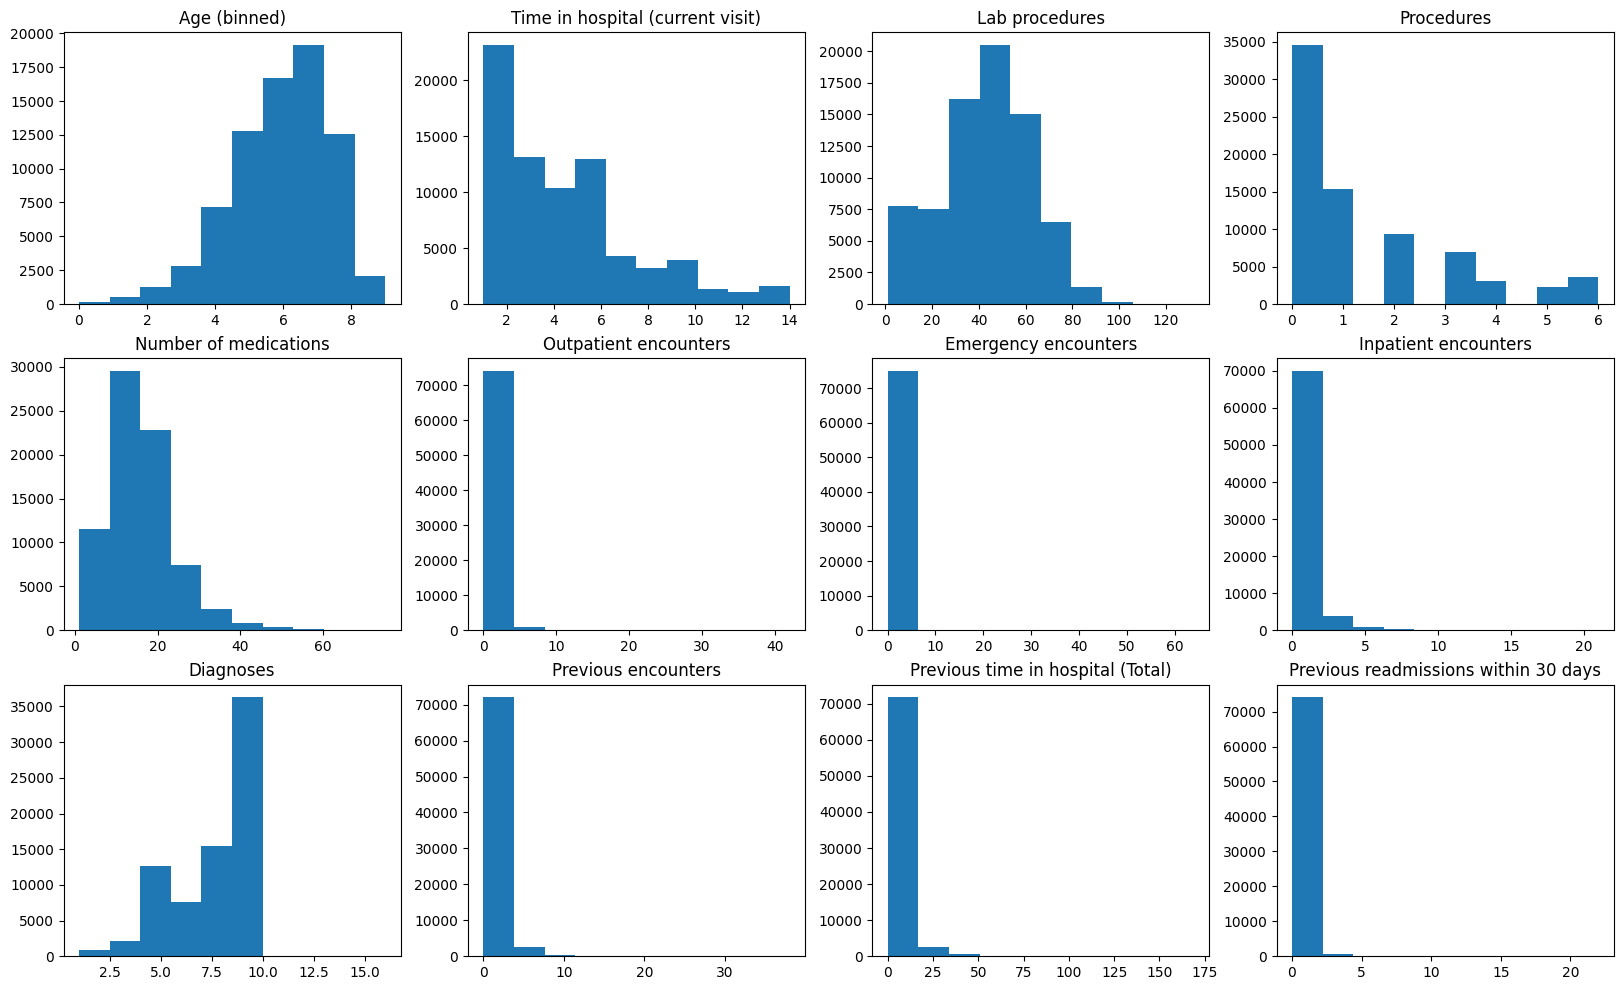

In [124]:
fig, ax = plt.subplots(3,4, figsize=(20, 12))
figsize=(8, 6)
ax[0,0].hist(X_train['age'])
ax[0,0].set_title("Age (binned)")
ax[0,1].hist(X_train['time_in_hospital'])
ax[0,1].set_title("Time in hospital (current visit)")
ax[0,2].hist(X_train['num_lab_procedures'])
ax[0,2].set_title("Lab procedures")
ax[0,3].hist(X_train['num_procedures'])
ax[0,3].set_title("Procedures")
ax[1,0].hist(X_train['num_medications'])
ax[1,0].set_title("Number of medications")
ax[1,1].hist(X_train['number_outpatient'])
ax[1,1].set_title("Outpatient encounters")
ax[1,2].hist(X_train['number_emergency'])
ax[1,2].set_title("Emergency encounters")
ax[1,3].hist(X_train['number_inpatient'])
ax[1,3].set_title("Inpatient encounters")
ax[2,0].hist(X_train['number_diagnoses'])
ax[2,0].set_title("Diagnoses")
ax[2,1].hist(X_train['prev_encounters'])
ax[2,1].set_title("Previous encounters")
ax[2,2].hist(X_train['prev_time_hospital'])
ax[2,2].set_title("Previous time in hospital (Total)")
ax[2,3].hist(X_train['prev_readmit_less30'])
ax[2,3].set_title("Previous readmissions within 30 days")

Several of the variables don't take on many different values, so not all scatterplots are particularly revealing. It appears there's a non-linear relationship between number of lab procedures and number of medications. And unsurprisingly, previous number of encounters and previous time spent in the hospital are correlated.

(I selected some of the variables with more variation to plot, since a full matrix of 12 variables plotted against each other was difficult to read)

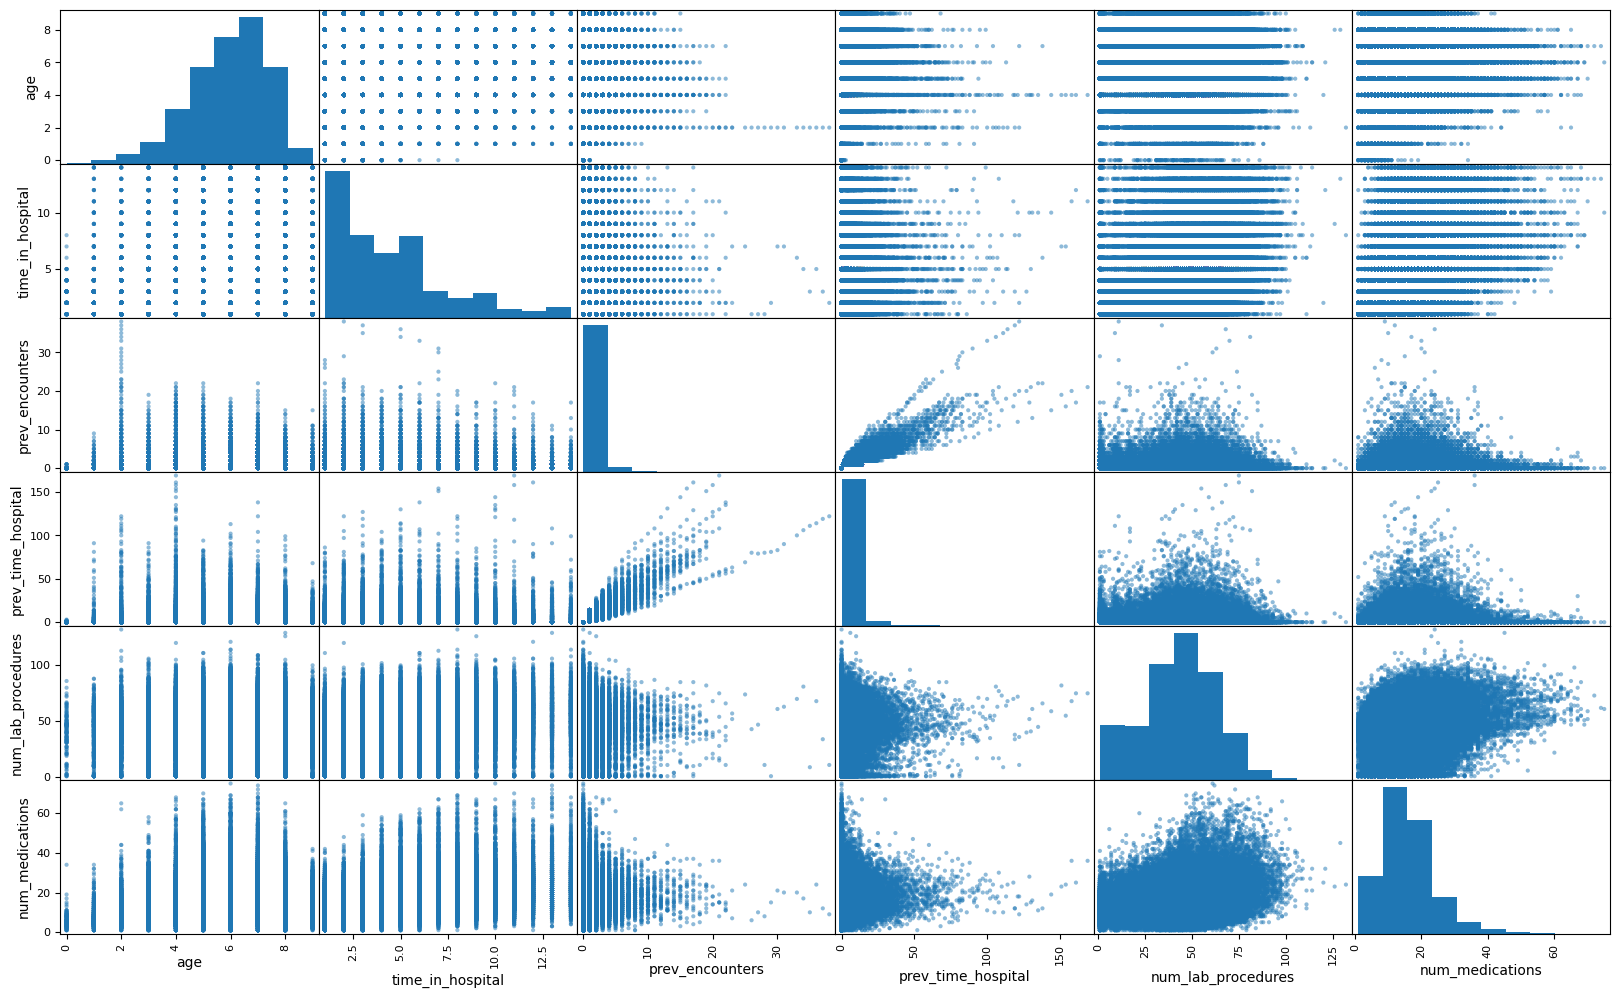

In [149]:
scatter_matrix(X_train[['age', 'time_in_hospital', 'prev_encounters', 'prev_time_hospital', 'num_lab_procedures', 'num_medications']], figsize=(20, 12));

# Variable transformations

(Most of these are unlikely to be used for model fitting)

## Squared

Text(0.5, 1.0, 'Squared - Medications')

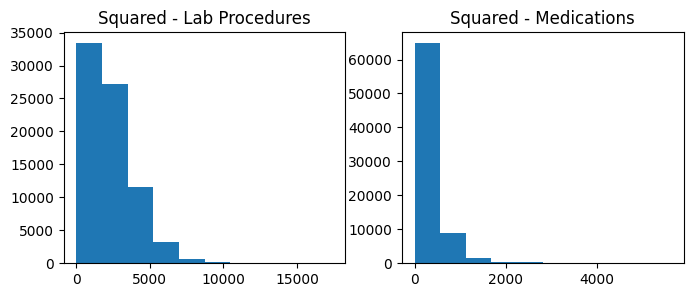

In [155]:
# Squared variables
fig, ax = plt.subplots(1,2, figsize=(8, 3))
ax[0].hist(X_train['num_lab_procedures']**2)
ax[0].set_title("Squared - Lab Procedures")
ax[1].hist(X_train['num_medications']**2)
ax[1].set_title("Squared - Medications")

array([[<Axes: xlabel='lab_squared', ylabel='lab_squared'>,
        <Axes: xlabel='meds_squared', ylabel='lab_squared'>],
       [<Axes: xlabel='lab_squared', ylabel='meds_squared'>,
        <Axes: xlabel='meds_squared', ylabel='meds_squared'>]],
      dtype=object)

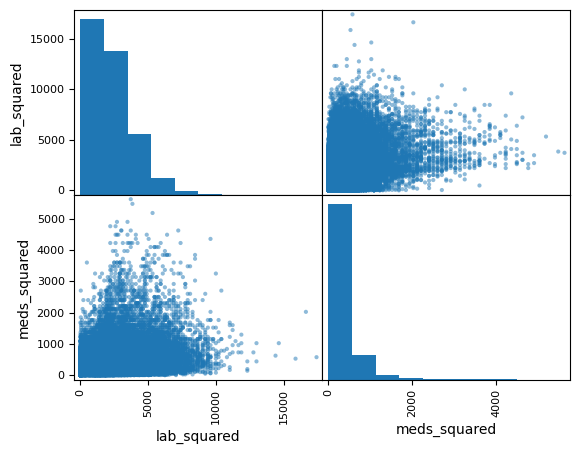

In [158]:
scatter_matrix(pd.DataFrame({'lab_squared': X_train['num_lab_procedures']**2, 'meds_squared': X_train['num_medications']**2}))

## Cubed

Text(0.5, 1.0, 'Cubed - Medications')

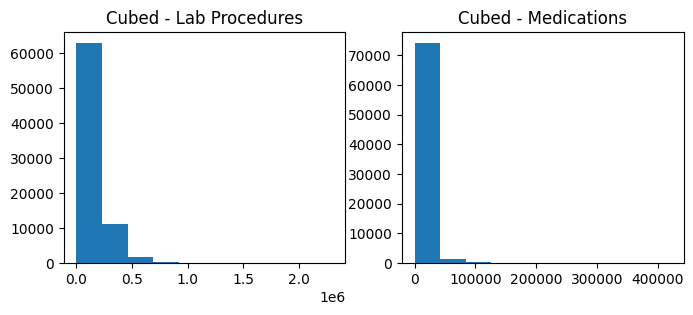

In [159]:
fig, ax = plt.subplots(1,2, figsize=(8, 3))
ax[0].hist(X_train['num_lab_procedures']**3)
ax[0].set_title("Cubed - Lab Procedures")
ax[1].hist(X_train['num_medications']**3)
ax[1].set_title("Cubed - Medications")

array([[<Axes: xlabel='lab_cubed', ylabel='lab_cubed'>,
        <Axes: xlabel='meds_cubed', ylabel='lab_cubed'>],
       [<Axes: xlabel='lab_cubed', ylabel='meds_cubed'>,
        <Axes: xlabel='meds_cubed', ylabel='meds_cubed'>]], dtype=object)

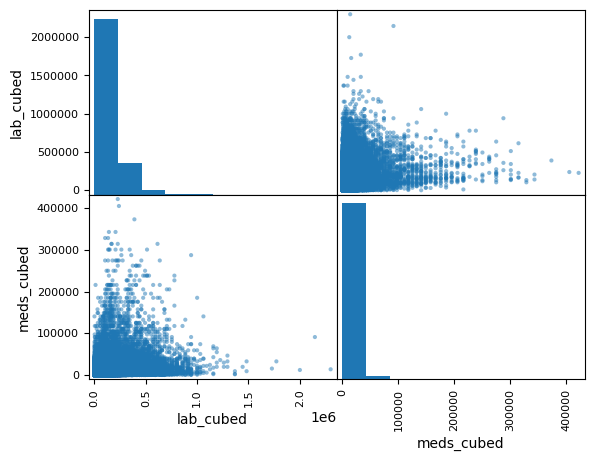

In [160]:
scatter_matrix(pd.DataFrame({'lab_cubed': X_train['num_lab_procedures']**3, 'meds_cubed': X_train['num_medications']**3}))

## Exponentiation

Text(0.5, 1.0, 'Exp - Medications')

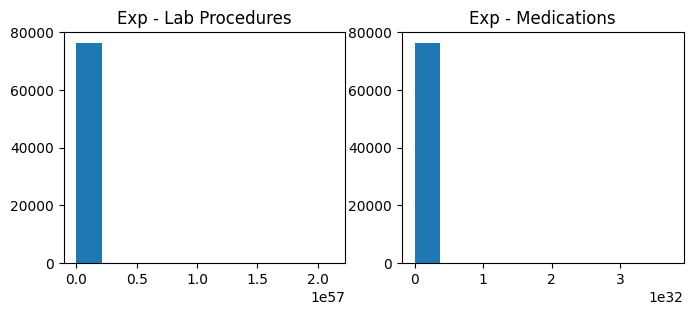

In [161]:
fig, ax = plt.subplots(1,2, figsize=(8, 3))
ax[0].hist(np.exp(X_train['num_lab_procedures']))
ax[0].set_title("Exp - Lab Procedures")
ax[1].hist(np.exp(X_train['num_medications']))
ax[1].set_title("Exp - Medications")

/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/misc.py:121: RuntimeWarning: invalid value encountered in cast
  if np.all(locs == locs.astype(int)):


array([[<Axes: xlabel='lab_exp', ylabel='lab_exp'>,
        <Axes: xlabel='meds_exp', ylabel='lab_exp'>],
       [<Axes: xlabel='lab_exp', ylabel='meds_exp'>,
        <Axes: xlabel='meds_exp', ylabel='meds_exp'>]], dtype=object)

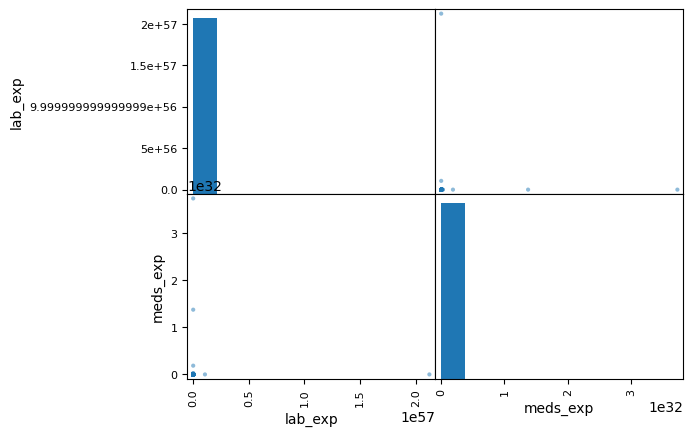

In [162]:
# Definitely not useful!!
scatter_matrix(pd.DataFrame({'lab_exp': np.exp(X_train['num_lab_procedures']), 'meds_exp': np.exp(X_train['num_medications'])}))

## Log

Text(0.5, 1.0, 'Log - Medications')

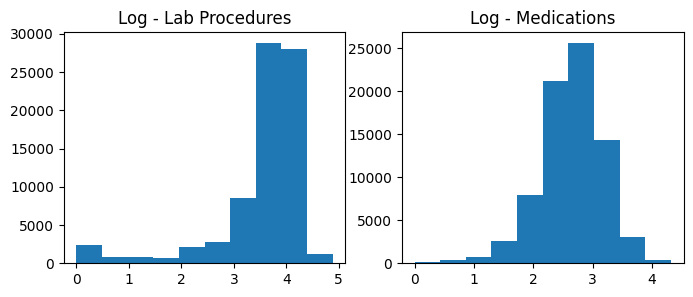

In [163]:
fig, ax = plt.subplots(1,2, figsize=(8, 3))
ax[0].hist(np.log(X_train['num_lab_procedures']))
ax[0].set_title("Log - Lab Procedures")
ax[1].hist(np.log(X_train['num_medications']))
ax[1].set_title("Log - Medications")

array([[<Axes: xlabel='lab_log', ylabel='lab_log'>,
        <Axes: xlabel='meds_log', ylabel='lab_log'>],
       [<Axes: xlabel='lab_log', ylabel='meds_log'>,
        <Axes: xlabel='meds_log', ylabel='meds_log'>]], dtype=object)

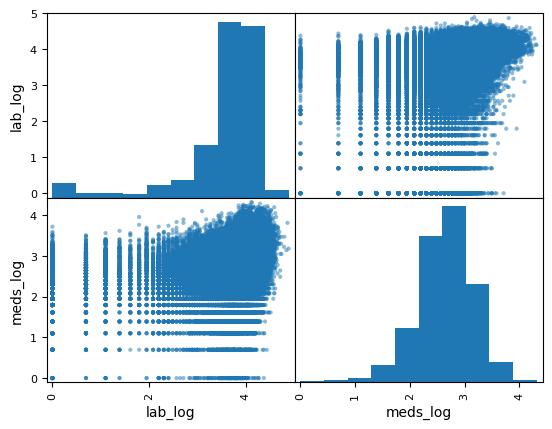

In [164]:
scatter_matrix(pd.DataFrame({'lab_log': np.log(X_train['num_lab_procedures']), 'meds_log': np.log(X_train['num_medications'])}))